## Imports: libraries and dataset

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import itertools
from statsmodels.tsa.stattools import adfuller

import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR

from sklearn.preprocessing import StandardScaler

In [10]:
# Load the dataset
df = pd.read_csv('../../dataset/KAG_energydata_complete.csv')

# Convert the 'date' column to datetime format and set it as the index
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

Standardize the dataset

In [11]:
scaler = StandardScaler()
target_series = df['Appliances']
target_series_scaled = scaler.fit_transform(target_series.values.reshape(-1, 1)).flatten()

## Sarima model

In [12]:
split_ratio = 0.8
split_index = int(len(target_series_scaled) * split_ratio)
train_series = target_series_scaled[:split_index]
test_series = target_series_scaled[split_index:]

In [13]:
sarima_predictions = []
actuals = []
batch_size = 300

for i in range(0, len(test_series), batch_size):
    end_index = i + batch_size if i + batch_size < len(test_series) else len(test_series)
    train_window = np.concatenate([train_series, test_series[:i]])
    
    # Fit SARIMA model
    sarima_model = SARIMAX(train_window,
                           order=(2, 0, 2),
                           seasonal_order=(1, 0, 1, 24),
                           enforce_stationarity=False,
                           enforce_invertibility=False)
    sarima_model_fit = sarima_model.fit(disp=False)
    
    # Forecast
    forecast = sarima_model_fit.forecast(steps=end_index - i)
    sarima_predictions.extend(forecast)
    actuals.extend(test_series[i:end_index])


In [14]:
sarima_predictions_unscaled = scaler.inverse_transform(np.array(sarima_predictions).reshape(-1, 1)).flatten()
actuals_unscaled = scaler.inverse_transform(np.array(actuals).reshape(-1, 1)).flatten()

In [15]:
sarima_mae = mean_absolute_error(actuals_unscaled, sarima_predictions_unscaled)
sarima_mse = mean_squared_error(actuals_unscaled, sarima_predictions_unscaled)
sarima_rmse = np.sqrt(sarima_mse)
sarima_r2 = r2_score(actuals_unscaled, sarima_predictions_unscaled)

print('Mean Absolute Error (MAE):', sarima_mae)
print('Mean Squared Error (MSE):', sarima_mse)
print('Root Mean Squared Error (RMSE):', sarima_rmse)
print('R-squared:', sarima_r2)

Mean Absolute Error (MAE): 51.24174820586188
Mean Squared Error (MSE): 8077.143808535234
Root Mean Squared Error (RMSE): 89.87293145622453
R-squared: 0.02544278224629204


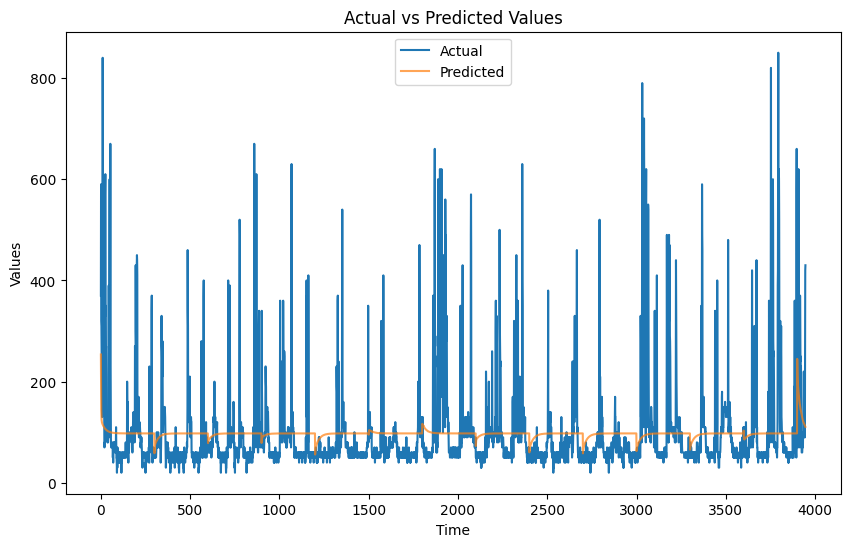

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(actuals_unscaled, label='Actual')
plt.plot(sarima_predictions_unscaled, label='Predicted', alpha=0.7)
plt.title('Actual vs Predicted Values')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.show()
